# 1. Load Modules

In [ ]:
import os
import struct
import time
import random
import numpy as np
from math import e
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt


from models.baseline import CNN_DF, AE_DF
from train import train_deepfaker
#from evaluate import evaluate_deepfaker


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_dir = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/dataset/raw"
checkpoint_dir_CNN_DF = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_CNN_DF"
checkpoint_dir_AE_DF = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_AE_DF"


# 2. Time Test

## 2.1 Augmented Dataset

In [17]:
# Global Variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_dir = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/dataset/raw"
checkpoint_dir_CNN_DF = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_CNN_DF"
checkpoint_dir_AE_DF = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_AE_DF"
batch_size = 32
num_epochs = 1
checkpoint_interval = 20

# Ensure checkpoint directories exist
os.makedirs(checkpoint_dir_CNN_DF, exist_ok=True)
os.makedirs(checkpoint_dir_AE_DF, exist_ok=True)

# 1. Load Dataset
train_loader = create_data_loader(dataset_dir)

# 2. Models Instantiation
cnn_model = CNN_DF()
ae_model = AE_DF(input_dim=128 * 128)

'''
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training.")
    cnn_model = torch.nn.DataParallel(cnn_model)
    ae_model = torch.nn.DataParallel(ae_model)
    '''

# 3. Train

# 3.2 CNN
print("Training CNN_DF model...")
train_deepfaker(
    model=cnn_model,
    train_loader=train_loader,
    checkpoint_dir=checkpoint_dir_CNN_DF,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    checkpoint_interval=checkpoint_interval,
)
# 3.1 Autoencoder
print("Training AE_DF model...")
train_deepfaker(
    model=ae_model,
    train_loader=train_loader,
    checkpoint_dir=checkpoint_dir_AE_DF,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    checkpoint_interval=checkpoint_interval,
)



print("Training completed for both models.")


Training CNN_DF model...
Using 2 GPUs for training.
Epoch [1/1], Loss: 0.1946
Total training time: 188.34 seconds
Training AE_DF model...
Using 2 GPUs for training.
Epoch [1/1], Loss: 0.2152
Total training time: 188.65 seconds
Training completed for both models.


## 2.2 Unaugmented Dataset

In [21]:
# Global Variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_dir = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/dataset/raw"
checkpoint_dir_CNN_DF = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_CNN_DF"
checkpoint_dir_AE_DF = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_AE_DF"
batch_size = 32
num_epochs = 1
checkpoint_interval = 20

# Ensure checkpoint directories exist
os.makedirs(checkpoint_dir_CNN_DF, exist_ok=True)
os.makedirs(checkpoint_dir_AE_DF, exist_ok=True)

# 1. Load Dataset
train_loader = create_data_loader(dataset_dir)

# 2. Models Instantiation
cnn_model = CNN_DF()
ae_model = AE_DF(input_dim=128 * 128)

'''
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training.")
    cnn_model = torch.nn.DataParallel(cnn_model)
    ae_model = torch.nn.DataParallel(ae_model)
    '''

# 3. Train

# 3.2 CNN
print("Training CNN_DF model...")
train_deepfaker(
    model=cnn_model,
    train_loader=train_loader,
    checkpoint_dir=checkpoint_dir_CNN_DF,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    checkpoint_interval=checkpoint_interval,
)
# 3.1 Autoencoder
print("Training AE_DF model...")
train_deepfaker(
    model=ae_model,
    train_loader=train_loader,
    checkpoint_dir=checkpoint_dir_AE_DF,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    checkpoint_interval=checkpoint_interval,
)



print("Training completed for both models.")


Training CNN_DF model...
Using 2 GPUs for training.
Epoch [1/1], Loss: 0.2010
Total training time: 187.43 seconds
Training AE_DF model...
Using 2 GPUs for training.
Epoch [1/1], Loss: 0.2159
Total training time: 188.02 seconds
Training completed for both models.


In [31]:
import os
import random
import numpy as np

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFilter


def set_seed(seed=42):
    """
    Set seed for reproducibility across Python, NumPy, and PyTorch.

    Args:
        seed (int): The seed value to set. Default is 42.
    """
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 


def worker_init_fn(worker_id):
    """
    Initialize each DataLoader worker with a seed.
    """
    seed = torch.initial_seed() % (2**32)
    np.random.seed(seed)
    random.seed(seed)


set_seed(42)

class MultiscaleImageDataset(Dataset):
    """
    Custom dataset for loading multiscale images stored in .tiff format.
    """
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory containing the raw images (./Multiscale_Image_Dataset/raw/).
            transform (callable, optional): Optional transform to be applied on each image.
        """
        self.root_dir = root_dir
        self.transform = transform        
        self.image_paths = [
            os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".tiff")
        ]

        if not self.image_paths:
            raise FileNotFoundError(f"No .tiff images found in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image




class AugmentedMultiscaleImageDataset(Dataset):
    """
    Augmented dataset for loading and augmenting multiscale images.
    """
    def __init__(self, root_dir, transform=None, target_size=1000):
        """
        Args:
            root_dir (str): Directory containing the raw images (./Multiscale_Image_Dataset/raw/).
            transform (callable, optional): Transform to apply to each image.
            target_size (int): Total number of augmented images to create. Default is 10000.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size        
        self.image_paths = [
            os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".tiff")
        ]

        if not self.image_paths:
            raise FileNotFoundError(f"No .tiff images found in {root_dir}")

        self.base_size = len(self.image_paths) 

    def __len__(self):
        return self.target_size

    def __getitem__(self, idx):        
        torch.manual_seed(idx)
        random.seed(idx)
        
        original_idx = idx % self.base_size
        img_path = self.image_paths[original_idx]
        image = Image.open(img_path).convert("L")
        
        augmentation_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.RandomCrop((512, 512), pad_if_needed=True)            
        ])

        augmented_image = augmentation_transform(image)
        
        if self.transform:
            augmented_image = self.transform(augmented_image)

        return augmented_image


def create_data_loader(root_dir, batch_size=32, mode="train"):
    """
    Creates a DataLoader for training or evaluation.

    Args:
        root_dir (str): Directory containing the raw dataset.
        batch_size (int): Batch size for the DataLoader. Default is 32.
        target_size (int): Total number of augmented images to create. Default is 10000.
        mode (str): Mode for the DataLoader ("train" or "eval"). Default is "train".

    Returns:
        DataLoader: A DataLoader instance for the dataset.
    """
    if mode not in ["train", "eval"]:
        raise ValueError(f"Mode must be 'train' or 'eval', got {mode}.")

    # Define transformations
    
    bright_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: transforms.functional.adjust_brightness(img, 2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])


    bright_dataset = AugmentedMultiscaleImageDataset(root_dir=dataset_dir, transform=bright_transform)
    bright_loader = DataLoader(bright_dataset,
                               batch_size=batch_size,
                               shuffle=(mode=="train"),
                               num_workers=4,
                               worker_init_fn=worker_init_fn)
    return bright_loader


In [32]:
# Global Variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_dir = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/dataset/raw"
checkpoint_dir_CNN_DF = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_CNN_DF"
checkpoint_dir_AE_DF = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_AE_DF"
batch_size = 32
num_epochs = 1
checkpoint_interval = 20

# Ensure checkpoint directories exist
os.makedirs(checkpoint_dir_CNN_DF, exist_ok=True)
os.makedirs(checkpoint_dir_AE_DF, exist_ok=True)

# 1. Load Dataset
train_loader = create_data_loader(dataset_dir)

# 2. Models Instantiation
cnn_model = CNN_DF()
ae_model = AE_DF(input_dim=128 * 128)

'''
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training.")
    cnn_model = torch.nn.DataParallel(cnn_model)
    ae_model = torch.nn.DataParallel(ae_model)
    '''

# 3. Train

# 3.2 CNN
print("Training CNN_DF model...")
train_deepfaker(
    model=cnn_model,
    train_loader=train_loader,
    checkpoint_dir=checkpoint_dir_CNN_DF,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    checkpoint_interval=checkpoint_interval,
)
# 3.1 Autoencoder
print("Training AE_DF model...")
train_deepfaker(
    model=ae_model,
    train_loader=train_loader,
    checkpoint_dir=checkpoint_dir_AE_DF,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    checkpoint_interval=checkpoint_interval,
)



print("Training completed for both models.")


Training CNN_DF model...
Using 2 GPUs for training.
Epoch [1/1], Loss: 0.4266
Total training time: 20.47 seconds
Training AE_DF model...
Using 2 GPUs for training.
Epoch [1/1], Loss: 0.2379
Total training time: 21.19 seconds
Training completed for both models.


# 3. Evaluation

In [26]:
def set_seed(seed=42):
    """
    Set seed for reproducibility across Python, NumPy, and PyTorch.

    Args:
        seed (int): The seed value to set. Default is 42.
    """
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

def worker_init_fn(worker_id):
    """
    Initialize each DataLoader worker with a seed.
    """
    seed = torch.initial_seed() % (2**32)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

class AugmentedMultiscaleImageDataset(Dataset):
    """
    Augmented dataset for loading and augmenting multiscale images.
    """
    def __init__(self, root_dir, transform=None, target_size=1000):
        """
        Args:
            root_dir (str): Directory containing the raw images (./Multiscale_Image_Dataset/raw/).
            transform (callable, optional): Transform to apply to each image.
            target_size (int): Total number of augmented images to create. Default is 10000.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size        
        self.image_paths = [
            os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".tiff")
        ]

        if not self.image_paths:
            raise FileNotFoundError(f"No .tiff images found in {root_dir}")

        self.base_size = len(self.image_paths) 

    def __len__(self):
        return self.target_size

    def __getitem__(self, idx):        
        torch.manual_seed(idx)
        random.seed(idx)
        
        original_idx = idx % self.base_size
        img_path = self.image_paths[original_idx]
        image = Image.open(img_path).convert("L")
        
        augmentation_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.RandomCrop((512, 512), pad_if_needed=True)            
        ])

        augmented_image = augmentation_transform(image)
        
        if self.transform:
            augmented_image = self.transform(augmented_image)

        return augmented_image


def create_data_loader(root_dir, batch_size=32, mode="train"):
    """
    Creates a DataLoader for training or evaluation.

    Args:
        root_dir (str): Directory containing the raw dataset.
        batch_size (int): Batch size for the DataLoader. Default is 32.
        target_size (int): Total number of augmented images to create. Default is 10000.
        mode (str): Mode for the DataLoader ("train" or "eval"). Default is "train".

    Returns:
        DataLoader: A DataLoader instance for the dataset.
    """
    if mode not in ["train", "eval"]:
        raise ValueError(f"Mode must be 'train' or 'eval', got {mode}.")
    
    bright_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: transforms.functional.adjust_brightness(img, 2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

    bright_dataset = AugmentedMultiscaleImageDataset(root_dir=dataset_dir, transform=bright_transform)
    bright_loader = DataLoader(bright_dataset,
                               batch_size=batch_size,
                               shuffle=(mode=="train"),
                               num_workers=4,
                               worker_init_fn=worker_init_fn)
    return bright_loader

In [36]:

from torchvision.utils import make_grid

def eval_deepfaker(model, dataset, n_images=5, image_size=128):
    """
    Evaluates the DeepFaker model by reconstructing a few images and visualizing them in a row.

    Args:
        model (torch.nn.Module): The trained DeepFaker model.
        dataset (torch.utils.data.Dataset): The dataset for evaluation.
        n_images (int): Number of images to reconstruct and compare.
        image_size (int): Size of each image (assumes square images, default: 128).
    """
    # Get a batch of original images
    original_imgs = torch.stack([dataset[i] for i in range(n_images)])  # Stack n_images for evaluation
    with torch.no_grad():
        original_imgs = original_imgs.to(next(model.parameters()).device)
        res = model(original_imgs)
        reconstructed_imgs = res['decoded'].cpu() 

    # Plot original and reconstructed images in a row
    fig, axes = plt.subplots(2, n_images, figsize=(15, 5))  # 2 rows: original, reconstructed

    for i in range(n_images):
        # Original image
        original_image = original_imgs[i].squeeze().cpu().numpy()  # Squeeze and convert to NumPy
        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')

        # Reconstructed image
        reconstructed_image = reconstructed_imgs[i].squeeze().numpy()  # Squeeze and convert to NumPy
        axes[1, i].imshow(reconstructed_image, cmap='gray')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


def evaluate_deepfaker(checkpoint_dir, test_loader, model, images_plot):
    """
    Evaluates the DeepFaker model using the latest checkpoint and visualizes results.

    Args:
        checkpoint_dir (str): Directory containing the checkpoint files.
        test_loader (DataLoader): DataLoader for the test dataset.
        model (torch.nn.Module): The DeepFaker model to evaluate.
    """
    # Ensure the checkpoint directory exists
    if not os.path.exists(checkpoint_dir):
        raise FileNotFoundError(f"Checkpoint directory {checkpoint_dir} not found!")

    # List and identify the latest checkpoint
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if not checkpoints:
        raise FileNotFoundError("No checkpoints found in the specified directory!")

    # Find the latest checkpoint based on the epoch number in the filename
    latest_checkpoint = max(checkpoints, key=lambda f: int(f.split("_")[-1].split(".")[0]))
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    print(f"Loading latest checkpoint: {latest_checkpoint_path}")

    # Load the checkpoint
    checkpoint = torch.load(latest_checkpoint_path)

    # Load the model state
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    model.eval()
    print(f"Model loaded from epoch {checkpoint['epoch']}")

    # Plot training loss over epochs
    losses = checkpoint["losses"]
    epochs = list(range(1, len(losses) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, label="Training Loss")
    min_loss_idx = losses.index(min(losses))
    plt.scatter(epochs[min_loss_idx], min(losses), color="red",
                label=f"Lowest Loss: {min(losses):.4f} (Epoch {epochs[min_loss_idx]})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate and visualize reconstructed and latent images
    eval_deepfaker(model, test_loader.dataset, n_images=images_plot, image_size=128)


In [37]:
dataset_dir = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/dataset/raw"
eval_loader = create_data_loader(dataset_dir,mode="eval")
deep_faker=CNN_DF()

Loading latest checkpoint: /home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/src/checkpoints_main/cp_CNN_DF/checkpoint_epoch_1000.pth
Model loaded from epoch 1000


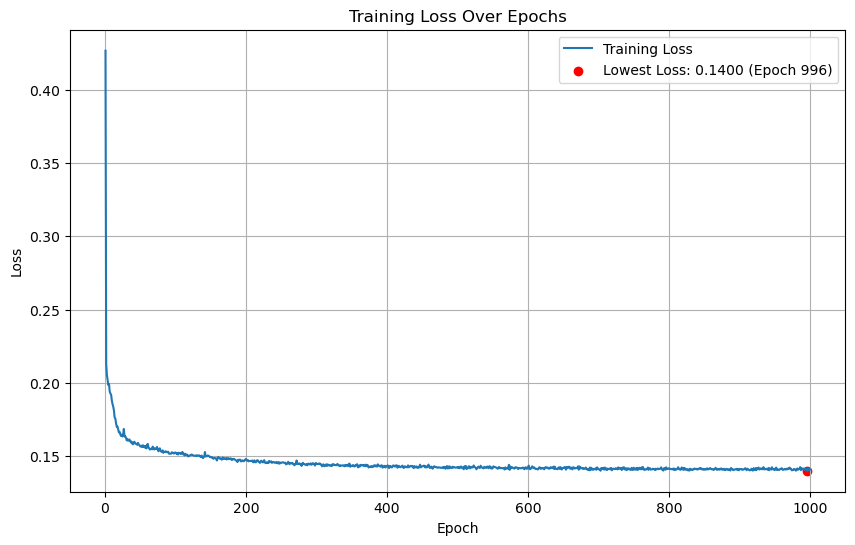

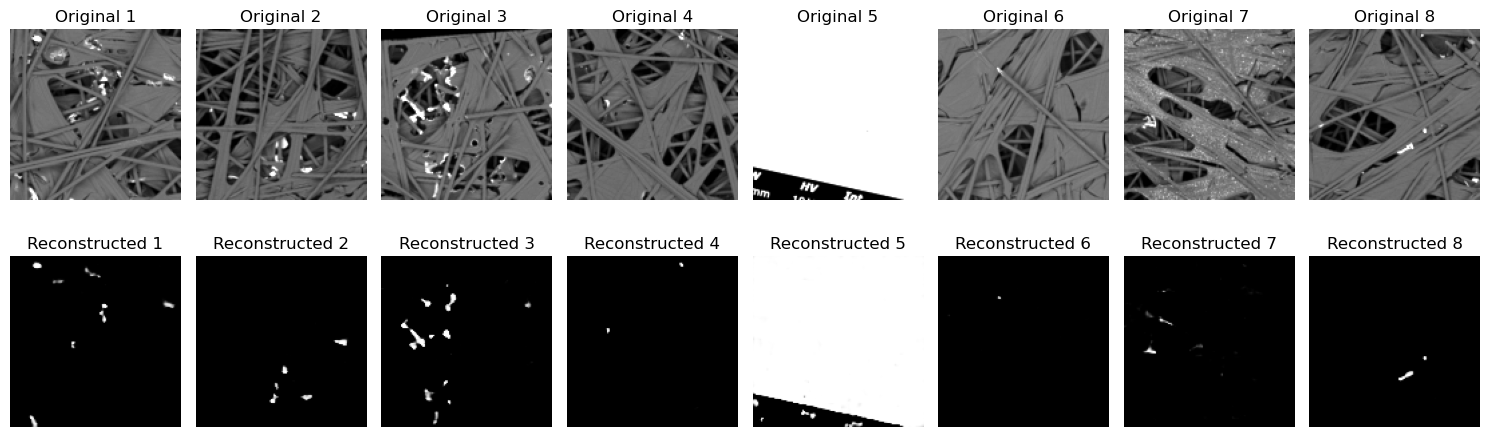

In [38]:
evaluate_deepfaker(checkpoint_dir_CNN_DF, eval_loader, deep_faker,8)